In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.math import confusion_matrix
from tensorflow.keras.losses import BinaryCrossentropy

from keras.models import Sequential
from keras.layers import Embedding, TextVectorization, Input, Dense, LSTM, Bidirectional, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

In [2]:
# Um Kompatibilitätsprobleme zu vermeiden
print(tf.__version__)

2.12.0


In [5]:
# Training mit GPU deutlich schneller
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices("GPU"))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# Einlesen der Trainingsdaten
data = pd.read_csv("/content/merged_data_2.csv")
len(data)

5000

<Axes: ylabel='class'>

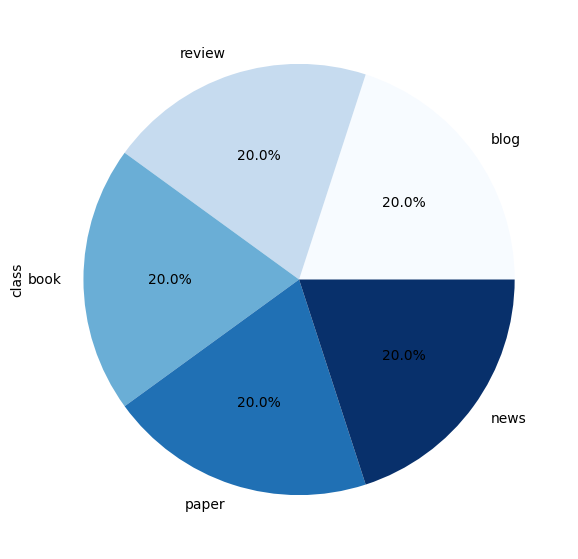

In [8]:
# Relative Klassenverteilung in Kreisdiagramm darstellen
data["class"].value_counts().plot.pie(cmap=plt.cm.Blues, figsize=(7, 7), autopct="%1.1f%%")

In [9]:
# Trotz Preprocessing könnten sich NaN-Werte einschleichen
data = data.dropna(how="any", axis=0)
len(data)

4999

In [10]:
pd.get_dummies(data["class"]).head(5)

,blog,book,news,paper,review
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [13]:
data.sample(5)

,text,class
1623,shipping was fast and loved the leds but today...,review
677,Big tech stocks have been in some hot water ov...,blog
1857,this is our second headset for our family head...,review
2392,"d.\nOn a piece of the stuff, broken off, he po...",book
3820,"This paper presents the task definition, resou...",paper


In [14]:
# Zielvariable per One-Hot-Kodierung in Zahlen umwandeln
X = data["text"]
y = pd.get_dummies(data["class"])

# 80% Trainingsdaten, 20% disjunkte Testdaten zur Evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=999)

In [15]:
# Anzahl von Token (Wörtern) im Vokabular
max_tokens = 10000

# Maximale Länge der Token-Sequenz
sequence_len = 256

# Diese Layer wird verwendet, um Textdaten in numerische Vektoren zu konvertieren
# Das Vokabular wird anhand der Trainingsdaten aufgestellt
vectorization_layer = TextVectorization(max_tokens=max_tokens, output_sequence_length=sequence_len)
vectorization_layer.adapt(X_train)

In [16]:
model = Sequential([
    # Eingabe eindimensionaler Strings
    Input(dtype=tf.string, shape=1),
    vectorization_layer,
    # Embedding-Layer konvertiert die Token-IDs in dichte Vektoren
    # Mit einer Ausgabedimension von 256, wobei mask_zero=True leere Token maskiert (Padding-Token)
    Embedding(input_dim=vectorization_layer.vocabulary_size(), output_dim=256, mask_zero=True),
    # Die Bidirektionalität ermöglicht dem LSTM, die Informationen sowohl in vorwärts- als auch rückwärtsgerichteten Richtungen zu verarbeiten
    Bidirectional(LSTM(512, return_sequences=True)),
    # Dropout-Schicht um Overfitting zu verhindern
    Dropout(0.03),
    Bidirectional(LSTM(256, return_sequences=True)),
    # Finale LSTM-Layer
    LSTM(64),
    # Sigmoid-Aktivierungsfunktion zur Klassifikation der 5 Klassen
    Dense(5, activation="sigmoid"),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 256)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 256, 256)          2560000   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 1024)        3149824   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256, 1024)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 512)         2623488   
 nal)                                                            
                                                        

In [17]:
# Kompilierung des Modells, Binary Crossentropy als Fehlerfunktion für Klassifikation
model.compile(optimizer="adam", loss=BinaryCrossentropy(), metrics=["accuracy"])

In [18]:
# Trainingshistorie (Epochen 1-10) über angepasste Datengrundlage
history = model.fit(X_train, y_train, epochs=10, validation_split=0.15)

Epoch 1/10
107/107 [==============================] - 174s 1s/step - loss: 0.5078 - accuracy: 0.2848 - val_loss: 0.4859 - val_accuracy: 0.3283
Epoch 2/10
107/107 [==============================] - 141s 1s/step - loss: 0.4334 - accuracy: 0.4225 - val_loss: 0.4427 - val_accuracy: 0.3633
Epoch 3/10
107/107 [==============================] - 127s 1s/step - loss: 0.3900 - accuracy: 0.4922 - val_loss: 0.3923 - val_accuracy: 0.4750
Epoch 4/10
107/107 [==============================] - 133s 1s/step - loss: 0.3701 - accuracy: 0.5116 - val_loss: 0.3814 - val_accuracy: 0.4467
Epoch 5/10
107/107 [==============================] - 124s 1s/step - loss: 0.3213 - accuracy: 0.5640 - val_loss: 0.3673 - val_accuracy: 0.5133
Epoch 6/10
107/107 [==============================] - 131s 1s/step - loss: 0.3121 - accuracy: 0.5734 - val_loss: 0.3541 - val_accuracy: 0.5383
Epoch 7/10
107/107 [==============================] - 121s 1s/step - loss: 0.2790 - accuracy: 0.6452 - val_loss: 0.2788 - val_accuracy: 0.6333

In [21]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

In [22]:
# Trainingshistorie (Epochen 11-15) über angepasste Datengrundlage
history = model.fit(X_train, y_train, epochs=5, validation_split=0.15)

Epoch 1/5
107/107 [==============================] - 126s 1s/step - loss: 0.1526 - accuracy: 0.8529 - val_loss: 0.2175 - val_accuracy: 0.7550
Epoch 2/5
107/107 [==============================] - 120s 1s/step - loss: 0.1092 - accuracy: 0.9094 - val_loss: 0.2168 - val_accuracy: 0.7667
Epoch 3/5
107/107 [==============================] - 115s 1s/step - loss: 0.0660 - accuracy: 0.9544 - val_loss: 0.2177 - val_accuracy: 0.8050
Epoch 4/5
107/107 [==============================] - 120s 1s/step - loss: 0.0621 - accuracy: 0.9585 - val_loss: 0.2164 - val_accuracy: 0.8150
Epoch 5/5
107/107 [==============================] - 130s 1s/step - loss: 0.0363 - accuracy: 0.9803 - val_loss: 0.1968 - val_accuracy: 0.8300


In [23]:
loss += history.history["loss"]
val_loss += history.history["val_loss"]
accuracy += history.history["accuracy"]
val_accuracy += history.history["val_accuracy"]

In [24]:
# Trainingshistorie (Epochen 16-20) über angepasste Datengrundlage
history = model.fit(X_train, y_train, epochs=5, validation_split=0.15)

Epoch 1/5
107/107 [==============================] - 116s 1s/step - loss: 0.0263 - accuracy: 0.9876 - val_loss: 0.1793 - val_accuracy: 0.8600
Epoch 2/5
107/107 [==============================] - 127s 1s/step - loss: 0.0190 - accuracy: 0.9935 - val_loss: 0.2261 - val_accuracy: 0.8517
Epoch 3/5
107/107 [==============================] - 126s 1s/step - loss: 0.0264 - accuracy: 0.9868 - val_loss: 0.2598 - val_accuracy: 0.8200
Epoch 4/5
107/107 [==============================] - 123s 1s/step - loss: 0.0157 - accuracy: 0.9950 - val_loss: 0.2221 - val_accuracy: 0.8467
Epoch 5/5
107/107 [==============================] - 126s 1s/step - loss: 0.0169 - accuracy: 0.9947 - val_loss: 0.2152 - val_accuracy: 0.8367


In [25]:
loss += history.history["loss"]
val_loss += history.history["val_loss"]
accuracy += history.history["accuracy"]
val_accuracy += history.history["val_accuracy"]

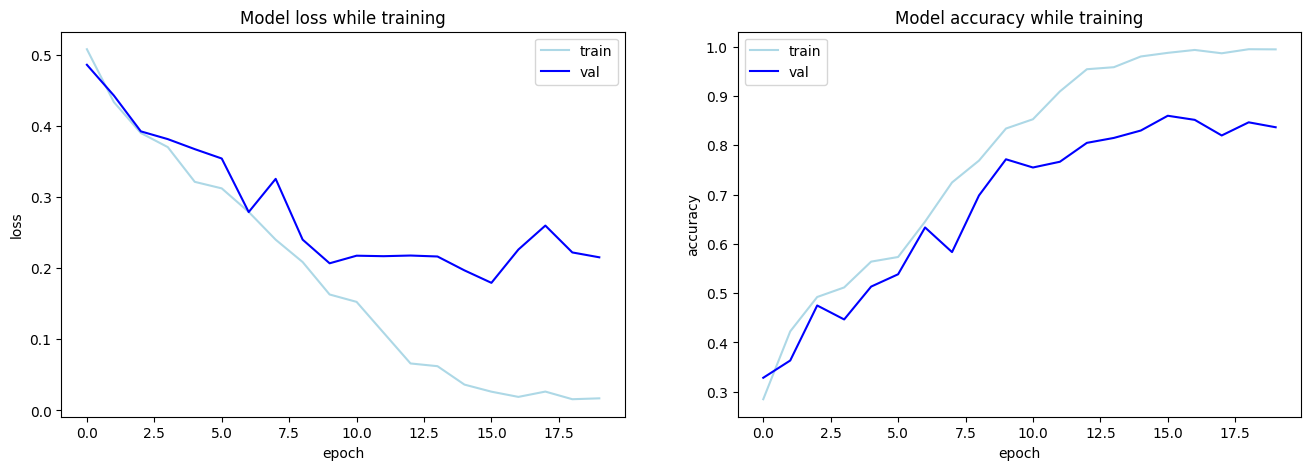

In [26]:
fig = plt.figure(figsize=(16, 5))

# Erster Subplot in einer 1x2-Rasteranordnung für Loss
ax = fig.add_subplot(1, 2, 1)
plt.plot(loss, color="lightblue")
plt.plot(val_loss, color="blue")
plt.title("Model loss while training")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"])

# Zweiter Subplot in einer 1x2-Rasteranordnung für Accuracy
fig.add_subplot(1, 2, 2)
plt.plot(accuracy, color="lightblue")
plt.plot(val_accuracy, color="blue")
plt.title("Model accuracy while training")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"])
plt.show()

In [ ]:
# Trainingshistorie bei alter Datengrundlage
history = model.fit(X_train, y_train, epochs=10, validation_split=0.15)

Epoch 1/10
1247/1247 [==============================] - 983s 772ms/step - loss: 0.1408 - accuracy: 0.8737 - val_loss: 0.0949 - val_accuracy: 0.9328
Epoch 2/10
1247/1247 [==============================] - 932s 748ms/step - loss: 0.0651 - accuracy: 0.9521 - val_loss: 0.0488 - val_accuracy: 0.9601
Epoch 3/10
1247/1247 [==============================] - 969s 778ms/step - loss: 0.0341 - accuracy: 0.9748 - val_loss: 0.0348 - val_accuracy: 0.9754
Epoch 4/10
1247/1247 [==============================] - 952s 764ms/step - loss: 0.0220 - accuracy: 0.9841 - val_loss: 0.0848 - val_accuracy: 0.9395
Epoch 5/10
1247/1247 [==============================] - 942s 756ms/step - loss: 0.0169 - accuracy: 0.9874 - val_loss: 0.0277 - val_accuracy: 0.9800
Epoch 6/10
1247/1247 [==============================] - 940s 754ms/step - loss: 0.0190 - accuracy: 0.9863 - val_loss: 0.0280 - val_accuracy: 0.9794
Epoch 7/10
1247/1247 [==============================] - 935s 751ms/step - loss: 0.0101 - accuracy: 0.9923 - val_

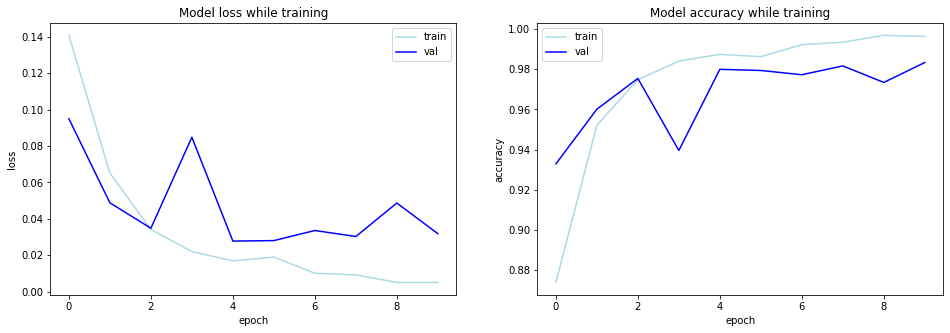

In [ ]:
fig = plt.figure(figsize=(16, 5))

# Erster Subplot in einer 1x2-Rasteranordnung für Loss
ax = fig.add_subplot(1, 2, 1)
plt.plot(loss, color="lightblue")
plt.plot(val_loss, color="blue")
plt.title("Model loss while training")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"])

# Zweiter Subplot in einer 1x2-Rasteranordnung für Accuracy
fig.add_subplot(1, 2, 2)
plt.plot(accuracy, color="lightblue")
plt.plot(val_accuracy, color="blue")
plt.title("Model accuracy while training")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"])
plt.show()

Trainingsdauer: 155 Minuten, 4GB VRAM, 10 Epochen

In [27]:
# Speichern des Models
model.save("models/classification_rnn_2.0")

## Evaluation RNN Version 1.0
(alte, ungleichgewichtete Datengrundlage)

In [ ]:
accuracy = model.evaluate(X_test, y_test, verbose=0)
print("test loss, test accuracy:", accuracy)

test loss, test accuracy: [0.02697935700416565, 0.983552098274231]


In [ ]:
y_pred = model.predict(X_test)
y_pred_int = np.round(y_pred)

# Über argmax wird die Klasse mit der höchsten Wahrscheinlichkeit ermittelt
confusion = confusion_matrix(labels=y_test.to_numpy().argmax(axis=1), predictions=y_pred_int.argmax(axis=1))

367/367 [==============================] - 39s 105ms/step


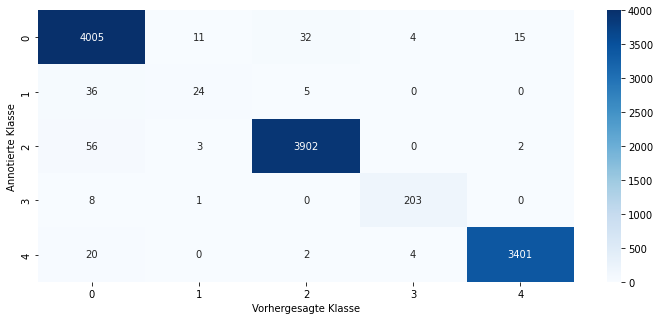

In [ ]:
plt.figure(figsize=(12,5))
sns.heatmap(confusion, annot=True, fmt="d", cmap=plt.cm.Blues)

plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Annotierte Klasse")
plt.show()

In [ ]:
y_test_max = y_test.to_numpy().argmax(axis=1)
y_pred_max = y_pred_int.argmax(axis=1)

print("Test Recall:", recall_score(y_test_max, y_pred_max, average="weighted"))
print("Test Precision:", precision_score(y_test_max, y_pred_max, average="weighted"))
print("Test F1-Score:", f1_score(y_test_max, y_pred_max, average="weighted"))

Test Recall: 0.9830407363217999
Test Precision: 0.9823067056225686
Test F1-Score: 0.9824831049682028


| Dummy Variable | Klasse |
|---|---|
| 0 | Blog |
| 1 | Buch |
| 2 | News |
| 3 | Paper |
| 4 | Review |

## Evaluation RNN Version 2.0
(mit neuer Datengrundlage)

In [28]:
accuracy = model.evaluate(X_test, y_test, verbose=0)
print("test loss, test accuracy:", accuracy)

test loss, test accuracy: [0.25870266556739807, 0.8119999766349792]


In [29]:
y_pred = model.predict(X_test)
y_pred_int = np.round(y_pred)

# Über die argmax-Funktion wird die Klasse mit der höchsten Wahrscheinlichkeit ermittelt
confusion = confusion_matrix(labels=y_test.to_numpy().argmax(axis=1), predictions=y_pred_int.argmax(axis=1))

32/32 [==============================] - 10s 122ms/step


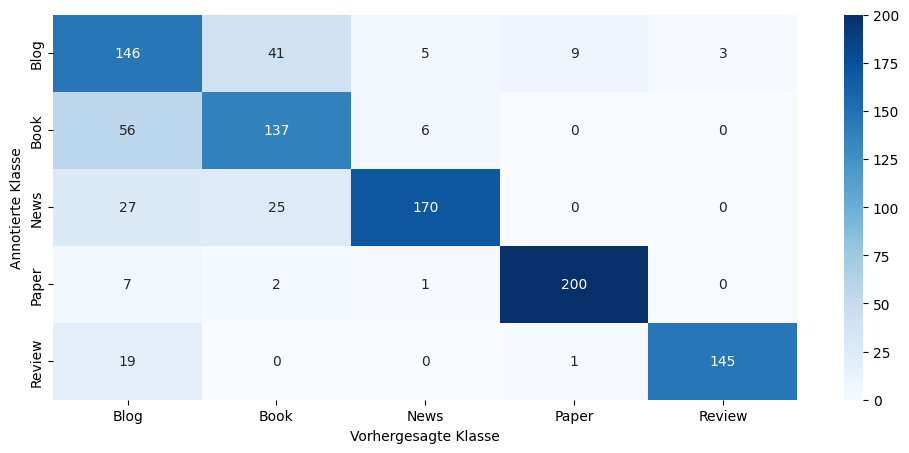

In [36]:
plt.figure(figsize=(12,5))
class_labels = ["Blog", "Book", "News", "Paper", "Review"]

sns.heatmap(confusion, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Annotierte Klasse")

plt.show()

In [31]:
y_test_max = y_test.to_numpy().argmax(axis=1)
y_pred_max = y_pred_int.argmax(axis=1)

print("Test Recall:", recall_score(y_test_max, y_pred_max, average="weighted"))
print("Test Precision:", precision_score(y_test_max, y_pred_max, average="weighted"))
print("Test F1-Score:", f1_score(y_test_max, y_pred_max, average="weighted"))

Test Recall: 0.798
Test Precision: 0.8188082866704819
Test F1-Score: 0.8044502068417704


## Demonstration

In [37]:
example_input = """
the book was in perfect condition and i enjoyed it a lot!
"""

# Zur Vorhersage muss der String in einem DataFrame vorliegen
pred = model.predict(pd.DataFrame([example_input]))

print(pred)
print(pred.argmax(axis=1))

1/1 [==============================] - 0s 125ms/step
[[9.8207209e-04 1.1982854e-03 7.3271350e-04 7.0369412e-04 9.9911767e-01]]
[4]


In [38]:
example_input = """
Air quality concerns continue as Canadian wildfire smoke covers the Northeast
The smoke in major metro areas, including New York, Boston, Philadelphia and Washington, D.C., was expected to cause unhealthy air for all groups.
"""

pred = model.predict(pd.DataFrame([example_input]))

print(pred)
print(pred.argmax(axis=1))

1/1 [==============================] - 0s 52ms/step
[[6.7393079e-02 1.5491914e-04 8.6276871e-01 3.0226461e-03 3.5835395e-03]]
[2]


In [39]:
example_input = """
One of the most expensive aspects of any cybercriminal operation is the time and effort it takes to constantly create large numbers of new throwaway email accounts.
Now a new service offers to help dramatically cut costs associated with large-scale spam and account creation campaigns, by paying people to sell their email account credentials
and letting customers temporarily rent access to a vast pool of established accounts at major providers.
"""

pred = model.predict(pd.DataFrame([example_input]))

print(pred)
print(pred.argmax(axis=1))

1/1 [==============================] - 0s 56ms/step
[[3.6138803e-01 3.3753365e-01 3.3123374e-02 8.2429163e-03 1.5937079e-04]]
[0]


In [ ]:
example_input = """
We propose and implement an interpretable machine learning classification model for Explainable AI (XAI) based on expressive Boolean formulas.
Potential applications include credit scoring and diagnosis of medical conditions. The Boolean formula defines a rule with tunable complexity (or interpretability),
according to which input data are classified. Such a formula can include any operator that can be applied to one or more Boolean variables, thus providing higher expressivity
compared to more rigid rule-based and tree-based approaches. The classifier is trained using native local optimization techniques, efficiently searching the space of feasible formulas.
Shallow rules can be determined by fast Integer Linear Programming (ILP) or Quadratic Unconstrained Binary Optimization (QUBO) solvers, potentially powered by special purpose hardware or quantum devices.
"""

pred = model.predict(pd.DataFrame([example_input]))

print(pred)
print(pred.argmax(axis=1))

1/1 [==============================] - 0s 198ms/step
[[9.0191578e-03 7.7632606e-02 9.0522490e-02 3.1605318e-01 2.7173874e-04]]
[3]
